## Regional Grain Size Model - eastern Australia

Dan Buscombe 7/5/22

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from pingouin import partial_corr
import pingouin as pg
from sklearn.model_selection import RepeatedKFold, cross_val_score


In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon, box

In [11]:
## load Bujan data

In [12]:
bujan_dat = pd.read_csv('../../../orig_data/bujan_et_al_data/Size-Slope-Data-Points.csv')
bujan_dat#.keys()

bujan_sand = bujan_dat[bujan_dat['Clast size (mm)']<2]

In [ ]:
## load eastern Oz data and remove low quality slopes

In [924]:
dataset = '../../../orig_data/australia/dataset_Australia_East_coast.geojson'

dfOz = gpd.read_file(dataset)

dfOz = dfOz[dfOz['d50']<=.8] #2
len(dfOz)

277

In [794]:
ind = np.where(dfOz['quality_flag']!='Low')[0]
len(ind)
dfOz = dfOz.iloc[ind]
len(dfOz)

271

In [795]:
ind = np.where(dfOz['distance_to_sample']<1000)[0]
len(ind)
dfOz = dfOz.iloc[ind]
len(dfOz)


256

In [796]:
dfOz.keys()

Index(['beach_id', 'beach_slope_average', 'width_ci_average', 'quality_flag',
       'mstr', 'hsig_median', 'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs',
       'sl_points_average', 'beach_length', 'coastal_region',
       'primary_comp_id', 'secondary_comp_id', 'd50', 'distance_to_sample',
       'latitude', 'longitude', 'Hs_mean', 'Hs_max', 'Tp_mean', 'Wdir_mean',
       'Wdir_weighted_mean', 'geometry'],
      dtype='object')

In [797]:
dfOz = dfOz.dropna()
# df.head()
len(dfOz)

256

In [798]:
# df_strat_mstr = dfOz.copy()

# num_cats=5
# num_samples_per_category = 14

# df_strat_mstr['category'] = pd.cut(dfOz['mstr'], num_cats)
# df_strat_mstr = df_strat_mstr.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)

# len(df_strat_mstr) #70

In [800]:
df_strat_lat = dfOz.copy()

num_cats=8
num_samples_per_category = 13

df_strat_lat['category'] = pd.cut(dfOz['latitude'], num_cats)
df_strat_lat = df_strat_lat.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)

len(df_strat_lat)

104

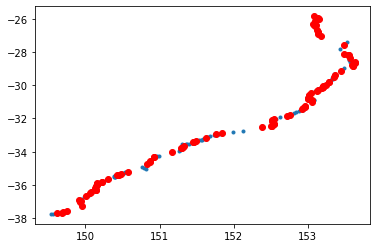

In [801]:
plt.plot(dfOz['longitude'], dfOz['latitude'],'.')

plt.plot(df_strat_lat['longitude'], df_strat_lat['latitude'],'ro')

In [540]:
### exploratory plots

In [802]:
df = df_strat_lat.copy()
df.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)

In [803]:
df.keys()

Index(['beach_id', 'beach_slope_average', 'width_ci_average', 'quality_flag',
       'mstr', 'hsig_median', 'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs',
       'sl_points_average', 'beach_length', 'coastal_region',
       'primary_comp_id', 'secondary_comp_id', 'd50', 'distance_to_sample',
       'latitude', 'longitude', 'hs_mean', 'hs_max', 'tp', 'dir',
       'Wdir_weighted_mean', 'geometry', 'category'],
      dtype='object')

(array([ 9., 16., 29., 21., 10., 11.,  5.,  1.,  1.,  1.]),
 array([0.1425 , 0.18221, 0.22192, 0.26163, 0.30134, 0.34105, 0.38076,
        0.42047, 0.46018, 0.49989, 0.5396 ]),
 <BarContainer object of 10 artists>)

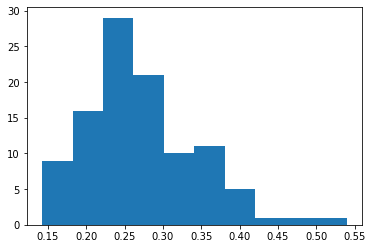

In [804]:
plt.hist(df['d50'])

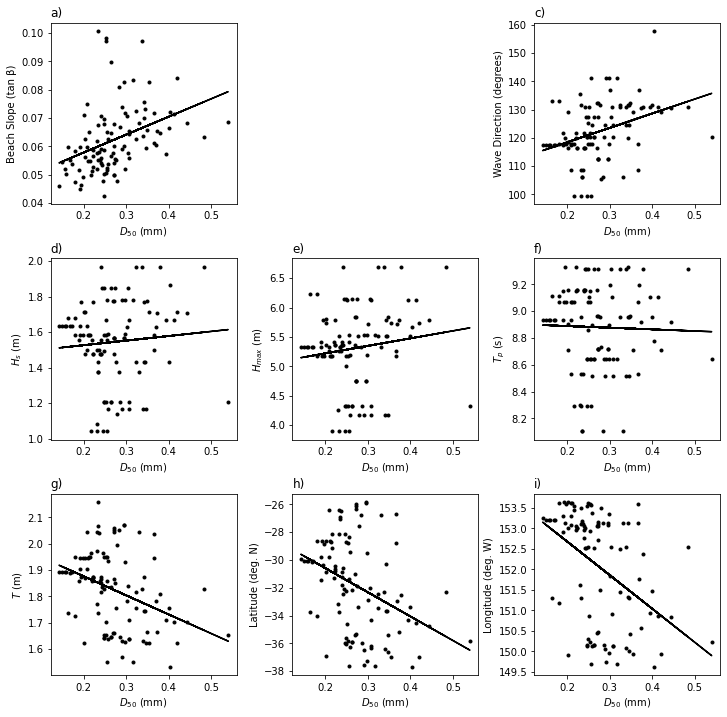

In [805]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(331)
plt.plot(df['d50'], df['beach_slope_average'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(df['d50'], df['beach_slope_average'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope_average']))**2
# plt.text(.1,.09,r'$R^2$='+str(r2)[:4])

# plt.subplot(332)
# plt.plot(df['d50'], df['trend'],'k.')
# plt.xlabel(r'$D_{50}$ (mm)')
# plt.ylabel('Shoreline trend (m/yr)')
# plt.title("b)", loc='left')

# coef = np.polyfit(df['d50'], df['trend'],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

# r2 = np.min(np.corrcoef(df['d50'], df['trend']))**2
# plt.text(.25,1.1,r'$R^2$='+str(r2)[:4])

plt.subplot(333)
plt.plot(df['d50'], df['dir'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Wave Direction (degrees)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['dir'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['dir']))**2
# plt.text(.25,170,r'$R^2$='+str(r2)[:4])

plt.subplot(334)
plt.plot(df['d50'], df['hs_mean'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_mean']))**2
# plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(335)
plt.plot(df['d50'], df['hs_max'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{max}$ (m)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_max']))**2
# plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(336)
plt.plot(df['d50'], df['tp'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['tp'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['tp']))**2
# plt.text(.25,6,r'$R^2$='+str(r2)[:4])

plt.subplot(337)
plt.plot(df['d50'],df['mstr'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("g)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
# plt.text(.25,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(338)
plt.plot(df['d50'],df['latitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg. N)')
plt.title("h)", loc='left')

coef = np.polyfit(df['d50'], df['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['latitude']))**2
# plt.text(.25,30,r'$R^2$='+str(r2)[:4])

plt.subplot(339)
plt.plot(df['d50'],df['longitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg. W)')
plt.title("i)", loc='left')

coef = np.polyfit(df['d50'], df['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['longitude']))**2
# plt.text(.25,-78,r'$R^2$='+str(r2)[:4])

# plt.savefig('data_plots/CGRASP_d50-linreg-df_strat_lat.jpg', dpi=300, bbox_inches='tight')

In [806]:
def mcfall(X,hs):
    if hs<=1:
        A = 3.1; n = -1.1 
    elif hs>=3:
        A = 3.9; n = -1.85         
    else:
        A = 2.1; n = -1.8             
    return (X/A)**(1/n)

In [807]:
def prc_err(y,yest):
    return 100*(np.abs(y-yest)/y)

In [808]:
def bujan(B,a,b,c):
    t1=(B-c)
    return (1/8)*(8*((t1/a))**(1/b)+1)

In [809]:
### Model - data stratified by latitude

In [810]:
X = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

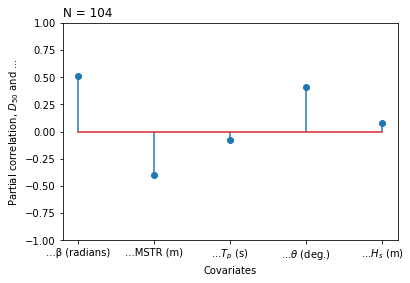

In [811]:

ax=plt.subplot(111)
plt.stem(X['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)','...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"N = {}".format(len(df)), loc='left')

plt.savefig('../data_plots/partial_correl_EAus.jpg', dpi=300, bbox_inches='tight')

In [552]:
## same variables as SEUS

In [934]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

test_size = 0.75

In [935]:
Smean = []
Sstd = []

In [936]:
# rand = np.random.randn(len(df))
# np.save('../model_out/EOz_rand.npy', rand, allow_pickle=True)

rand = np.load('../model_out/EOz_rand.npy', allow_pickle=True)

In [937]:
feature_names1 = ['β (radians)', r'$\theta$ (dir.)', 'MSTR (m)', 'Random (non-dim.)']
X = np.stack((df['beach_slope_average'],df['dir'],df['mstr'], rand))
X.shape

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model1 = ensemble.GradientBoostingRegressor(**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

The mean squared error (MSE) on test set: 0.0044


In [938]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1

In [939]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.074 (0.024)


In [940]:
feature_names2 = [r'β (radians)','MSTR (m)', 'Random (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['mstr'], rand))
X = np.stack((df['beach_slope_average'],df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['mstr'], rand))
X.shape

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model2 = ensemble.GradientBoostingRegressor(**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

The mean squared error (MSE) on test set: 0.0054


In [941]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2

In [942]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.071 (0.021)


In [943]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'], rand))
X.shape

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

The mean squared error (MSE) on test set: 0.0064


In [944]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3

In [945]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.073 (0.023)


In [946]:
feature_names4 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)','MSTR (m)','β', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'],df['mstr'], df['beach_slope_average'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'],df['mstr'], rand))
X.shape

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model4 = ensemble.GradientBoostingRegressor(**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

The mean squared error (MSE) on test set: 0.0057


In [947]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4

In [948]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.071 (0.024)


In [949]:
feature_names5 = ['MSTR (m)', 'Random (non-dim.)']
X = np.stack((df['mstr'], rand))
X.shape

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model5 = ensemble.GradientBoostingRegressor(**params)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

The mean squared error (MSE) on test set: 0.0053


In [950]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5

In [951]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.073 (0.021)


In [952]:
feature_names6 = ['β (m)', 'Random (non-dim.)']
X = np.stack((df['beach_slope_average'], rand))
# X = np.stack((df['beach_slope_median'], rand))
X.shape

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

The mean squared error (MSE) on test set: 0.0060


In [953]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6

In [954]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.072 (0.017)


In [955]:
Smean

[0.07439763486343995,
 0.07142900377211531,
 0.07334795427627712,
 0.07096925134682742,
 0.07262392626746635,
 0.07233446997428807]

In [956]:
ds_est_baseline = [mcfall(X,hs) for X,hs in zip(1/df['beach_slope_average'],df['hs_mean'])]

a = -0.154
b = -0.145
c = 0.268

ds_est_baseline2 = [bujan(B,a,b,c) for B in df['beach_slope_average']]

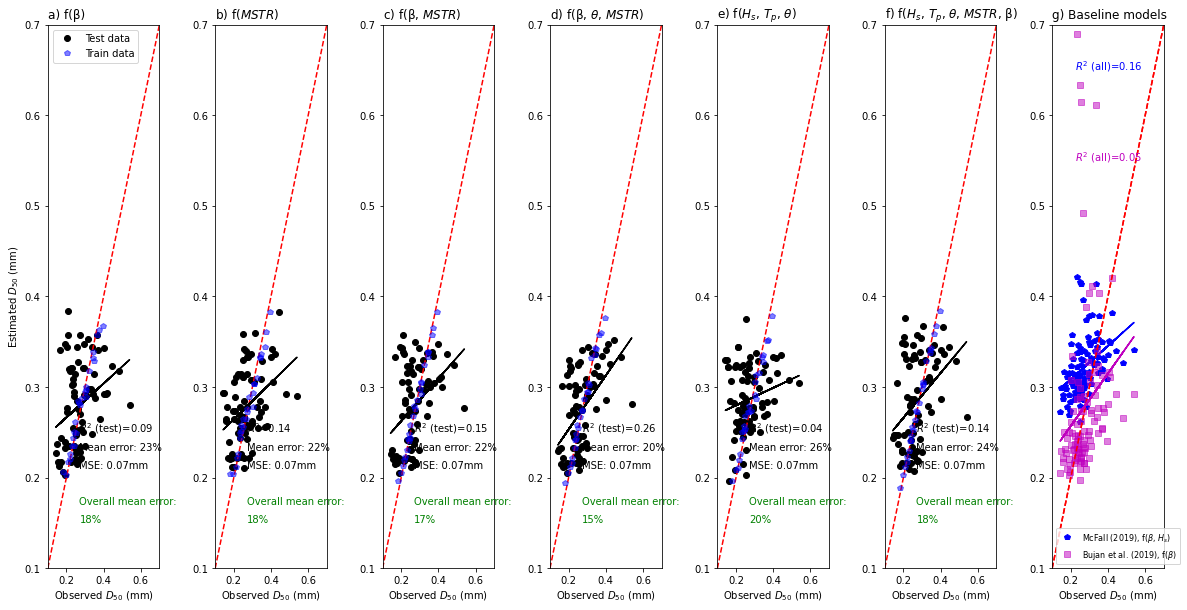

In [960]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.5, hspace=0.)

plt.subplot(171)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko', label='Test data')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(172)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.27,.25,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(173)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(174)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"d) f(β, $\theta$, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[0])[:4]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(175)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(176)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[3])[:4]))

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(177)
plt.plot(df['d50'], ds_est_baseline, 'bp', label=r'McFall (2019), f($\beta$, $H_s$)')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) Baseline models", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline))**2
plt.text(.22,.65,r'$R^2$ (all)='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'], ds_est_baseline,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')


plt.plot(df['d50'], ds_est_baseline2, 'ms', alpha=0.5, label=r"Bujan et al. (2019), f($\beta$)")
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"f) Bujan et al. (2019) relation, f($\beta$)", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline2))**2
plt.text(.22,.55,r'$R^2$ (all)='+str(r2)[:4], color='m')

coef = np.polyfit(df['d50'], ds_est_baseline2,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-m')
plt.legend(fontsize=8)

plt.savefig('../model_plots/EAus_d50-6model-baseline-skill.jpg', dpi=300, bbox_inches='tight')
# plt.close()

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

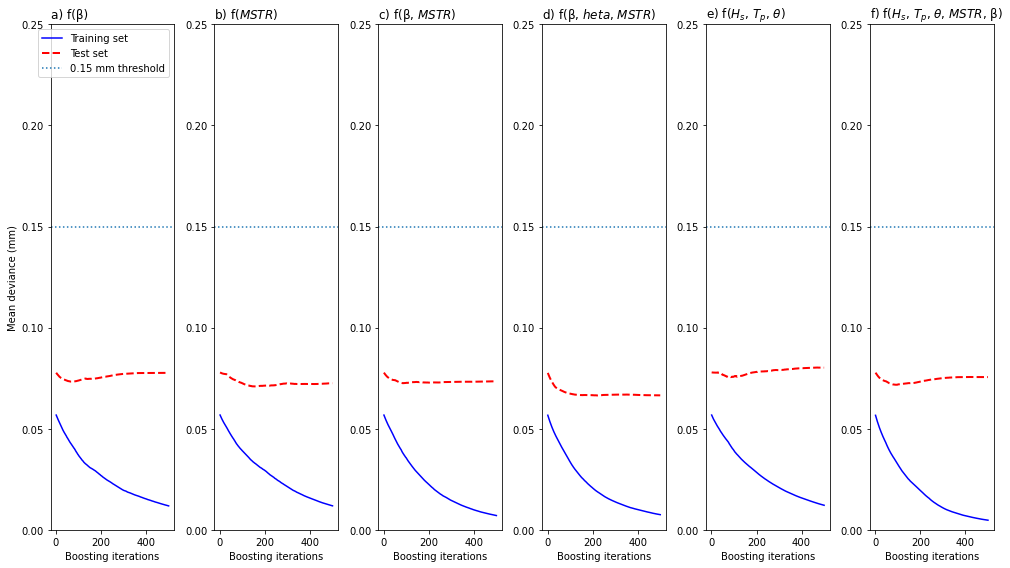

In [961]:
fig=plt.figure(figsize=(14,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)


####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)

plt.subplot(1, 6, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model6.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (mm)")
plt.ylim(0,.25)
plt.legend(loc="upper right")

###########################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)

plt.subplot(1, 6, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model5.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)


#############################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(1, 6, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model2.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)


#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)
    
plt.subplot(1, 6, 4)
plt.title("d) f(β, $\theta$, $MSTR$) ", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model1.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)
    
plt.subplot(1, 6, 5)
plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model3.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(1, 6, 6)
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model4.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

fig.tight_layout()
# plt.show()
plt.savefig('../model_plots/EAus_d50-6models-training-strat-lat.jpg', dpi=300, bbox_inches='tight')

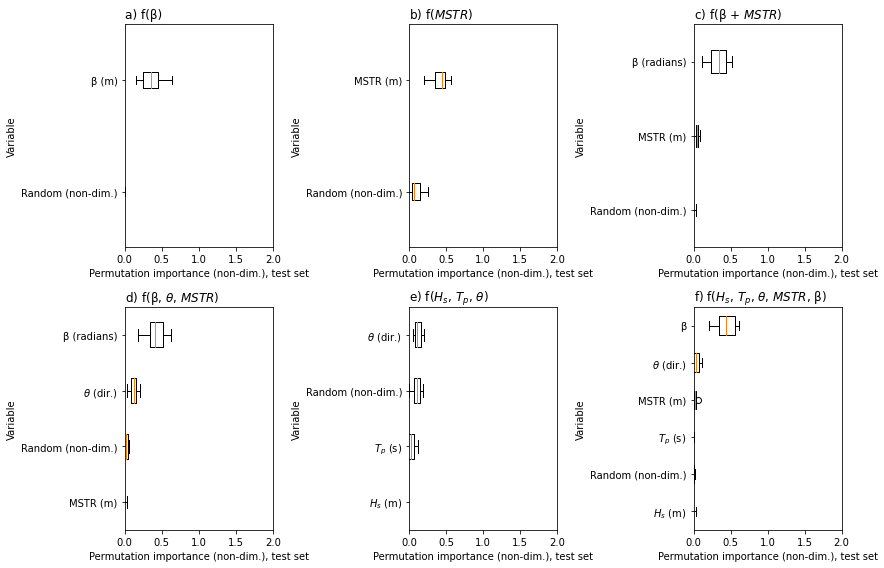

In [963]:

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

########################
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(231)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)

plt.xlim(0,2)
plt.title("a) f(β) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

#########################
result = permutation_importance(
    model5, X_test5, y_test5, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(232)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names5)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) f($MSTR$) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

#############################
result = permutation_importance(
    model2, X_test2, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(233)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("c) f(β + $MSTR$) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

############################
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(234)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) f(β, $\theta$, $MSTR$)", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

############################
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(235)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) f($H_s$, $T_p$, $\theta$) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

##################################
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(236)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β) ", loc='left')
plt.xlabel("Permutation importance (non-dim.), test set")
plt.ylabel("Variable")

fig.tight_layout()

plt.savefig('../model_plots/EAus_d50-6models-featimps-v2.jpg', dpi=300, bbox_inches='tight')


In [965]:
### save model

In [959]:
np.save('../model_out/dataset_Australia_East_coast_model1.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_Australia_East_coast_model2.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_Australia_East_coast_model3.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_Australia_East_coast_model4.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_Australia_East_coast_model5.npy', model5out, allow_pickle=True)
np.save('../model_out/dataset_Australia_East_coast_model6.npy', model6out, allow_pickle=True)

In [975]:
del df['category']

In [976]:
df.to_csv('../model_data/dataset_Australia_East_coast_stratsample-by-lat.csv') # 104 samples (no replacement)
df = pd.read_csv('../model_data/dataset_Australia_East_coast_stratsample-by-lat.csv')

In [977]:
len(df)

104

In [507]:
### optimized hyperparameters

In [840]:
from sklearn import preprocessing


In [896]:
# params = {
#     "n_estimators": 500,
#     "max_depth": 4,
#     "min_samples_split": 10,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }

# test_size = 0.75


params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.1, #0.01,
    "loss": "squared_error",
}

test_size = 0.75

In [897]:
yscaler = preprocessing.StandardScaler().fit(df['d50'].values.reshape(-1, 1))
y = yscaler.transform(df['d50'].values.reshape(-1, 1))

indices = np.arange(len(y))

In [898]:
Smean = []
Sstd = []

In [899]:
rand = np.load('EOz_rand.npy', allow_pickle=True)

In [900]:
feature_names1 = ['β (radians)', r'$\theta$ (dir.)', 'MSTR (m)', 'Random (non-dim.)']
X = np.stack((df['beach_slope_average'],df['dir'],df['mstr'], rand))
X.shape

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, y.ravel(), test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

model1 = ensemble.GradientBoostingRegressor(**params)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

0.5396
0.3947
The mean squared error (MSE) on test set: 0.0045


In [901]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1

In [902]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.076 (0.028)


In [903]:
feature_names2 = [r'β (radians)','MSTR (m)', 'Random (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['mstr'], rand))
X = np.stack((df['beach_slope_average'],df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['mstr'], rand))
X.shape

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, y.ravel(), test_size=test_size, random_state=2022, #df['d50']
)

#unscale y - we balanced it to sample equally among grain size bins
y_test2 = yscaler.inverse_transform(y_test2.reshape(-1, 1)).squeeze()
y_train2 = yscaler.inverse_transform(y_train2.reshape(-1, 1)).squeeze()

print(y_test2.max())
print(y_train2.max())

model2 = ensemble.GradientBoostingRegressor(**params)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

0.5396
0.3947
The mean squared error (MSE) on test set: 0.0052


In [904]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2

In [905]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.075 (0.027)


In [906]:
feature_names3 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'], rand))
X.shape

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, y.ravel(), test_size=test_size, random_state=2022 #df['d50']
)

#unscale y - we balanced it to sample equally among grain size bins
y_test3 = yscaler.inverse_transform(y_test3.reshape(-1, 1)).squeeze()
y_train3 = yscaler.inverse_transform(y_train3.reshape(-1, 1)).squeeze()

print(y_test3.max())
print(y_train3.max())

model3 = ensemble.GradientBoostingRegressor(**params)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

0.5396
0.3947
The mean squared error (MSE) on test set: 0.0071


In [907]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3

In [908]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.076 (0.022)


In [909]:
feature_names4 = [r'$H_s$ (m)', r'$T_p$ (s)', r'$\theta$ (dir.)','MSTR (m)','β', 'Random (non-dim.)']
X = np.stack((df['hs_mean'],df['tp'],df['dir'],df['mstr'], df['beach_slope_average'], rand))
# X = np.stack((df['hs_max'],df['tp'],df['dir'],df['mstr'], rand))
X.shape

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, y.ravel(), test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test4 = yscaler.inverse_transform(y_test4.reshape(-1, 1)).squeeze()
y_train4 = yscaler.inverse_transform(y_train4.reshape(-1, 1)).squeeze()

print(y_test4.max())
print(y_train4.max())

model4 = ensemble.GradientBoostingRegressor(**params)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

0.5396
0.3947
The mean squared error (MSE) on test set: 0.0051


In [910]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4

In [911]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.074 (0.027)


In [912]:
feature_names5 = ['MSTR (m)', 'Random (non-dim.)']
X = np.stack((df['mstr'], rand))
X.shape

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, y.ravel(), test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test5 = yscaler.inverse_transform(y_test5.reshape(-1, 1)).squeeze()
y_train5 = yscaler.inverse_transform(y_train5.reshape(-1, 1)).squeeze()

print(y_test5.max())
print(y_train5.max())

model5 = ensemble.GradientBoostingRegressor(**params)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

0.5396
0.3947
The mean squared error (MSE) on test set: 0.0051


In [913]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5

In [914]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.075 (0.025)


In [915]:
feature_names6 = ['β (m)', 'Random (non-dim.)']
X = np.stack((df['beach_slope_average'], rand))
# X = np.stack((df['beach_slope_median'], rand))
X.shape

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, y.ravel(), test_size=test_size, random_state=2022
)

#unscale y - we balanced it to sample equally among grain size bins
y_test6 = yscaler.inverse_transform(y_test6.reshape(-1, 1)).squeeze()
y_train6 = yscaler.inverse_transform(y_train6.reshape(-1, 1)).squeeze()

print(y_test6.max())
print(y_train6.max())

model6 = ensemble.GradientBoostingRegressor(**params)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

0.5396
0.3947
The mean squared error (MSE) on test set: 0.0057


In [916]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6

In [917]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.082 (0.021)


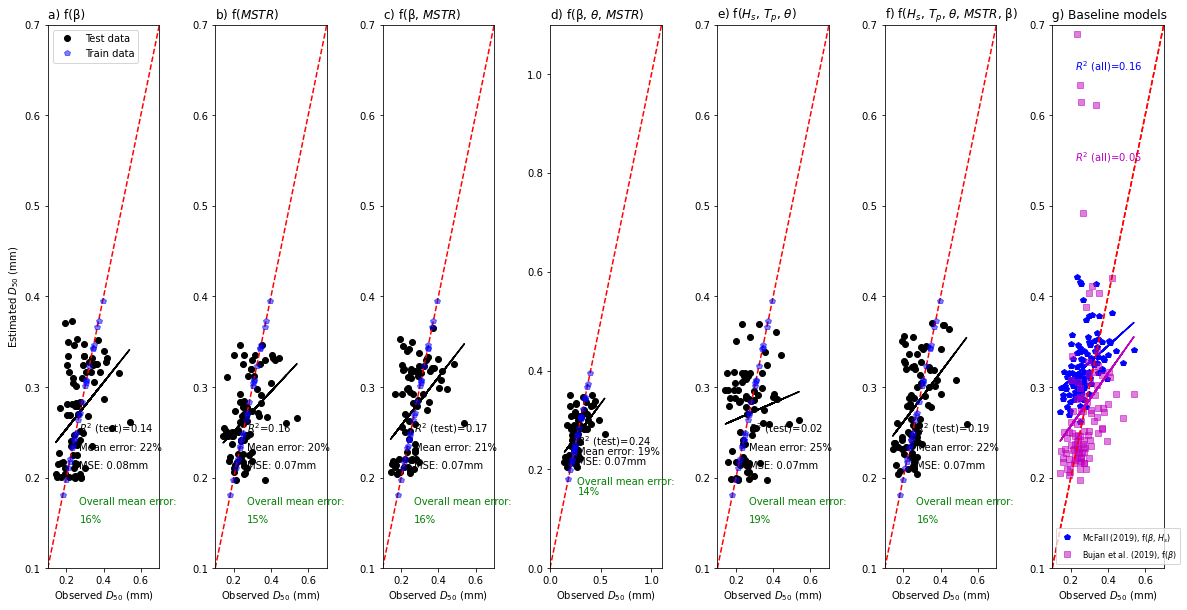

In [922]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.5, hspace=0.)

plt.subplot(171)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko', label='Test data')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(172)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.27,.25,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(173)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(174)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"d) f(β, $\theta$, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[0])[:4]))

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(175)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')

plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(176)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.27,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')
plt.text(.27,.23, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.27,.21, r'MSE: {}mm'.format(str(Smean[3])[:4]))

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.27,.17, r'Overall mean error:', color='g')
plt.text(.27,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(177)
plt.plot(df['d50'], ds_est_baseline, 'bp', label=r'McFall (2019), f($\beta$, $H_s$)')
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) Baseline models", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline))**2
plt.text(.22,.65,r'$R^2$ (all)='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'], ds_est_baseline,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-b')


plt.plot(df['d50'], ds_est_baseline2, 'ms', alpha=0.5, label=r"Bujan et al. (2019), f($\beta$)")
plt.xlim(.1,.7); plt.ylim(.1,.7)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
# plt.title(r"f) Bujan et al. (2019) relation, f($\beta$)", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline2))**2
plt.text(.22,.55,r'$R^2$ (all)='+str(r2)[:4], color='m')

coef = np.polyfit(df['d50'], ds_est_baseline2,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-m')
plt.legend(fontsize=8)

# plt.savefig('../model_plots/EAus_d50-5model-baseline-skill.jpg', dpi=300, bbox_inches='tight')
# # plt.close()

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

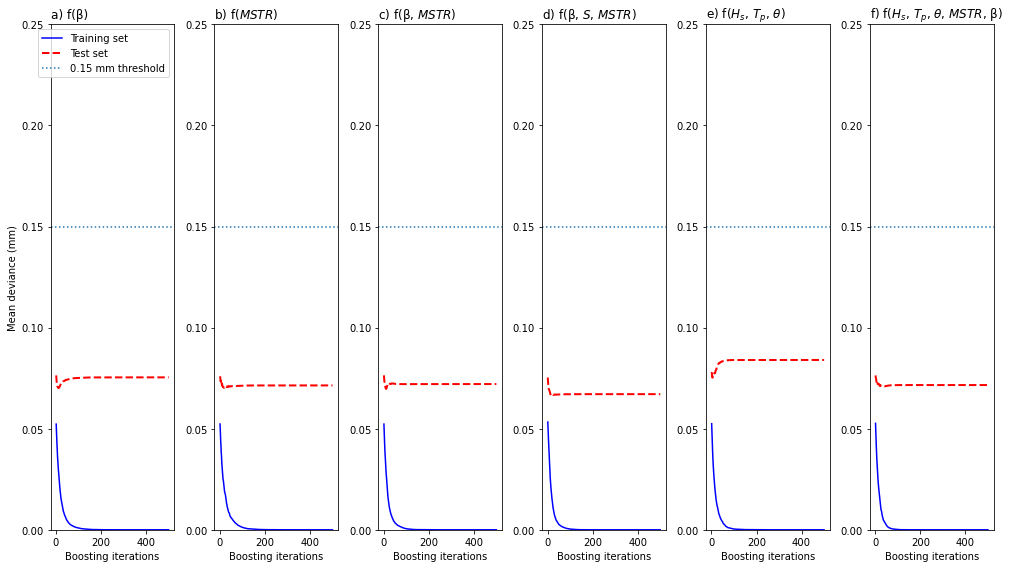

In [919]:
fig=plt.figure(figsize=(14,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)


####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)

plt.subplot(1, 6, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model6.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (mm)")
plt.ylim(0,.25)
plt.legend(loc="upper right")

###########################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)

plt.subplot(1, 6, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model5.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)


#############################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(1, 6, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model2.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)


#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)
    
plt.subplot(1, 6, 4)
plt.title("d) f(β, $S$, $MSTR$) ", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model1.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)
    
plt.subplot(1, 6, 5)
plt.title(r"e) f($H_s$, $T_p$, $\theta$)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model3.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

#####################
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(1, 6, 6)
plt.title(r"f) f($H_s$, $T_p$, $\theta$, $MSTR$, β)", loc='left')
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    np.sqrt(model4.train_score_),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, np.sqrt(test_score), "r--", label="Test set", lw=2
)
plt.axhline(0.15, linestyle=':',label='0.15 mm threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,.25)

fig.tight_layout()
# plt.show()
# plt.savefig('../model_plots/CGRASP_d50-4models-training-strat-lat.jpg', dpi=300, bbox_inches='tight')

Text(0.0, 1.0, 'j) ')

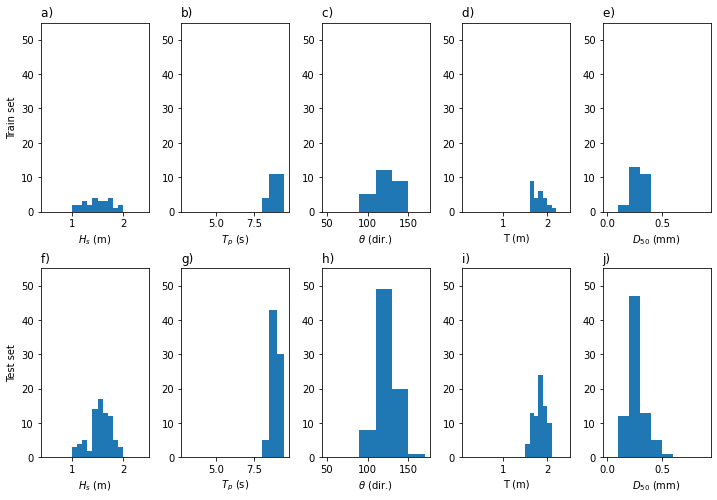

In [920]:
fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2,5,1)
plt.hist(X_train4[:,0], bins=np.arange(.5,2.5,.1))
plt.ylim(0,55); plt.ylabel('Train set'); plt.xlabel(r'$H_s$ (m)')
plt.title(r'a) ', loc='left')

plt.subplot(2,5,2)
plt.hist(X_train4[:,1], bins=np.arange(3,10,.5))
plt.ylim(0,55); plt.xlabel(r'$T_p$ (s)')
plt.title(r'b)', loc='left')

plt.subplot(2,5,3)
plt.hist(X_train4[:,2], bins=np.arange(50,180,20))
plt.ylim(0,55); plt.xlabel(r'$\theta$ (dir.)')
plt.title(r'c) ', loc='left')

plt.subplot(2,5,4)
plt.hist(X_train4[:,3], bins=np.arange(0.2,2.5,.1))
plt.ylim(0,55); plt.xlabel('T (m)')
plt.title(r'd) ', loc='left')

plt.subplot(2,5,5)
plt.hist(y_train4, bins=np.arange(0,1,.1))
plt.ylim(0,55); plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r'e) ', loc='left')

plt.subplot(2,5,6)
plt.hist(X_test4[:,0], bins=np.arange(.5,2.5,.1))
plt.ylim(0,55); plt.ylabel('Test set'); plt.xlabel(r'$H_s$ (m)')
plt.title(r'f) ', loc='left')

plt.subplot(2,5,7)
plt.hist(X_test4[:,1], bins=np.arange(3,10,.5))
plt.ylim(0,55); plt.xlabel(r'$T_p$ (s)')
plt.title(r'g)', loc='left')

plt.subplot(2,5,8)
plt.hist(X_test4[:,2], bins=np.arange(50,180,20))
plt.ylim(0,55); plt.xlabel(r'$\theta$ (dir.)')
plt.title(r'h) ', loc='left')

plt.subplot(2,5,9)
plt.hist(X_test4[:,3], bins=np.arange(0.2,2.5,.1))
plt.ylim(0,55); plt.xlabel('T (m)')
plt.title(r'i) ', loc='left')

plt.subplot(2,5,10)
plt.hist(y_test4, bins=np.arange(0,1,.1))
plt.ylim(0,55); plt.xlabel('$D_{50}$ (mm)')
plt.title(r'j) ', loc='left')

# plt.savefig('../data_plots/EAus_d50-test_train_dists.jpg', dpi=300, bbox_inches='tight')